## Import libraries and import data

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from math import ceil

import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,concatenate,Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K


from resnet50_d import identity_block
from resnet50_d import conv_block

C:\Users\Rahul\Anaconda3\envs\tensorflow_1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PATH=os.getcwd()
df_depth=pd.read_csv(PATH+'\\data\\depths.csv')
# df_depth_aug=pd.read_csv(PATH+'\\data\\depths_aug.csv')
# df_depth=pd.concat([df_depth,df_depth_aug],axis=0)

df_depth['id']=df_depth['id']+'.png'


## Plan or questions
* threshold optimization based on validation data
* stratification based on area coveres by masks
* try to use seaborn visualizations
* NOTE: If a ground truth is empty and you predict nothing, you get a perfect score for that image. If the ground truth is empty and you predict anything, you get a 0 for that image.
* Ensembling different parts of image or with different neuralnet

In [3]:


## import [training +mask] data and [testing data]
list_depths=[]
avg_int_imgs=[]
train_imgs = []
avg_int_masks=[]
train_masks = []
for img_path in glob(PATH+"\\data\\train\\images\\*"):#+glob(PATH+"\\data\\train\\aug_images\\*")
    
    n= cv2.imread(img_path)
    if np.average(n)!=0:
        n=np.array(n)
        n=cv2.resize(n,(101,101),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
        train_imgs.append(n)
        avg_int_imgs.append(np.average(n))
        
        
        mask_path=img_path.replace('images', 'masks')

        n_mask= cv2.imread(mask_path)
        n_mask=np.array(n_mask)
        n_mask=cv2.resize(n_mask,(101,101),interpolation = cv2.INTER_CUBIC)
        n_mask= cv2.cvtColor(n_mask,cv2.COLOR_BGR2GRAY)
        train_masks.append(n_mask)
        avg_int_masks.append(np.average(n_mask))
        list_depths.append(df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img_path))]['z'].values[0])
        
# list_depths_aug=[]
# # avg_int_imgs_aug=[]
# train_imgs_aug = []
# # avg_int_masks_aug=[]
# train_masks_aug = []

# for img_path in glob(PATH+"\\data\\train\\aug_images\\*"):#+glob(PATH+"\\data\\train\\aug_images\\*")
    
#     n= cv2.imread(img_path)
#     if np.average(n)!=0:
#         n=np.array(n)
#         n=cv2.resize(n,(128,128),interpolation = cv2.INTER_CUBIC)
#         n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
#         train_imgs_aug.append(n)
# #         avg_int_imgs.append(np.average(n))
        
        
#         mask_path=img_path.replace('images', 'masks')

#         n_mask= cv2.imread(mask_path)
#         n_mask=np.array(n_mask)
#         n_mask=cv2.resize(n_mask,(128,128),interpolation = cv2.INTER_CUBIC)
#         n_mask= cv2.cvtColor(n_mask,cv2.COLOR_BGR2GRAY)
#         train_masks_aug.append(n_mask)
# #         avg_int_masks.append(np.average(n_mask))
#         list_depths_aug.append(df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img_path))]['z'].values[0])
    
# len(list_depths_aug),len(list_depths)

## visualize images and their masks

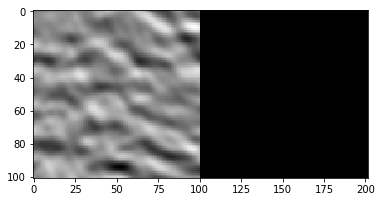

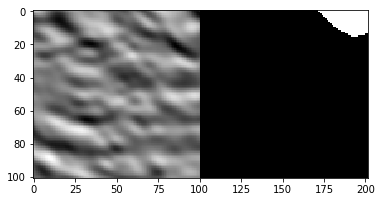

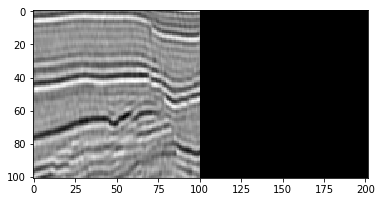

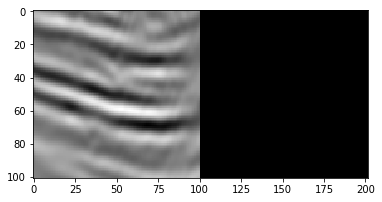

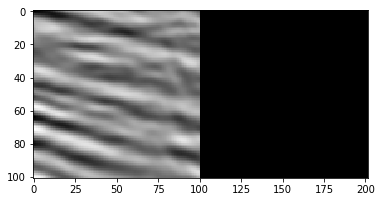

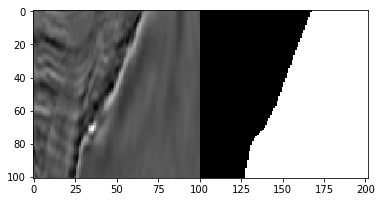

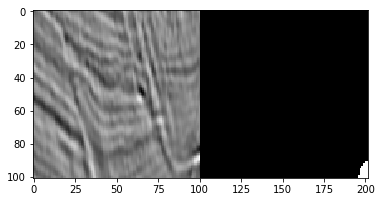

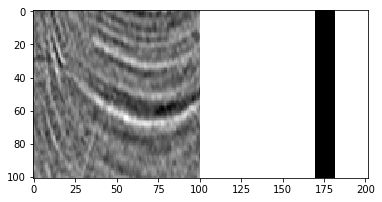

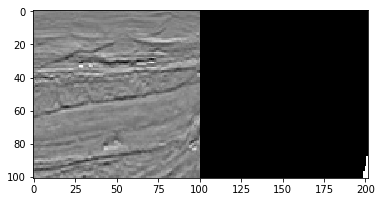

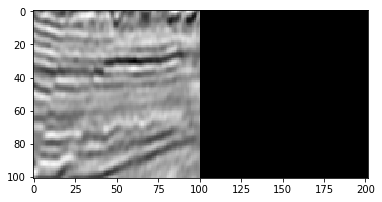

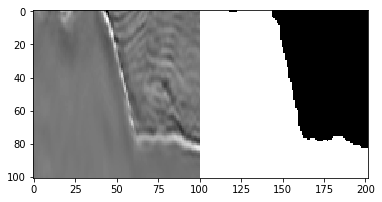

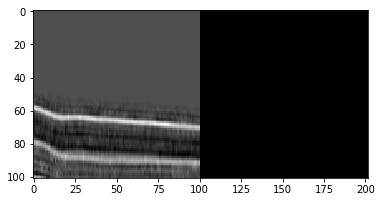

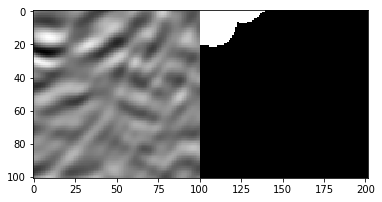

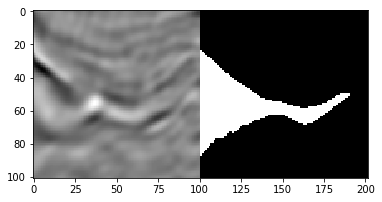

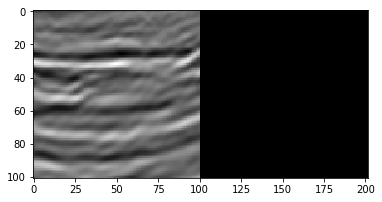

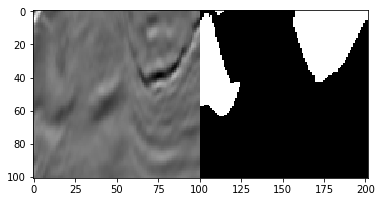

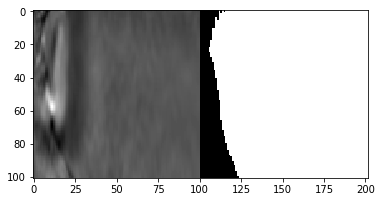

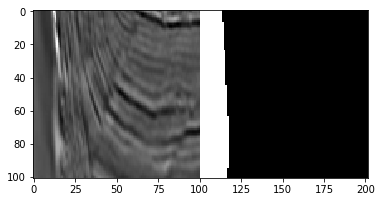

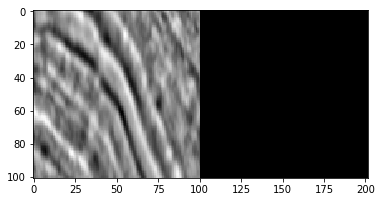

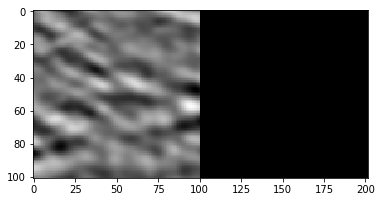

In [4]:
for i in range(20):
    plt.figure()
    plt.imshow(np.concatenate((train_imgs[i], train_masks[i]), axis=1),cmap='gray')

## 5 fold cross validation

In [5]:
ps=np.array([101,101])
cs=np.array([64,64])
ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])


In [6]:



def get_101_img_to_64(np_array):
    ps=np.array([101,101])
    cs=np.array([64,64])
    ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])
       
    
    np_array_1=np_array[:,:cs[0],:cs[0]]
    np_array_2=np_array[:,-cs[0]:,:cs[0]]
    np_array_3=np_array[:,:cs[0],-cs[0]:]
    np_array_4=np_array[:,-cs[0]:,-cs[0]:]
    np_array_mid=np_array[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]

    np_array_all=np.concatenate([np_array_1,np_array_2,np_array_3,np_array_4,np_array_mid],axis=0)

    print("Input shape : ",np_array.shape,"Output shape : ",np_array_all.shape)
    return np_array_all


# X_train.shape,get_101_img_to_64(X_train)

In [7]:
# train test split
df_train=pd.DataFrame()
df_train["imgs"]=train_imgs
df_train["depths"]=list_depths#[[[x]*128]*128 for x in list_depths]

print(set([ceil(x.flatten().sum()/(101.0*101.0*255)*10) for x in train_masks]))


from sklearn.model_selection import train_test_split
df_X_train, df_X_test, y_train, y_test = train_test_split(df_train, train_masks, test_size=0.2, random_state=1234,
                                                          stratify=[ceil(x.flatten().sum()/(101.0*101.0*255)) for x in train_masks])



## Prepare and Add augmentated data to training sample

# df_X_train_aug=pd.DataFrame(columns=['imgs','depths'])
# df_X_train_aug['imgs']=train_imgs_aug
# df_X_train_aug['depths']=list_depths_aug

# df_X_train=pd.concat([df_X_train,df_X_train_aug],axis=0)
# y_train=y_train+train_masks_aug


#normalize data
X_train=np.array(df_X_train['imgs'].values.tolist())
X_test=np.array(df_X_test['imgs'].values.tolist())
X_test_101_org=X_test.copy()
X_train=get_101_img_to_64(X_train)
X_test=get_101_img_to_64(X_test)


X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 64, 64, 1))    # adapt this if using 'channels_first' image data format
X_test = np.reshape(X_test, (len(X_test), 64, 64, 1))


y_train=np.array(y_train)
y_test=np.array(y_test)
y_test_101_org=y_test.copy()
y_train=get_101_img_to_64(y_train)
y_test=get_101_img_to_64(y_test)

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.
y_train = np.reshape(y_train, (len(y_train), 64, 64, 1))    # adapt this if using 'channels_first' image data format
y_test = np.reshape(y_test, (len(y_test), 64, 64, 1))

df_X_train.shape,df_X_test.shape,len(y_train),len(y_train[0])
# y_train


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Input shape :  (3136, 101, 101) Output shape :  (15680, 64, 64)
Input shape :  (784, 101, 101) Output shape :  (3920, 64, 64)
Input shape :  (3136, 101, 101) Output shape :  (15680, 64, 64)
Input shape :  (784, 101, 101) Output shape :  (3920, 64, 64)


((3136, 2), (784, 2), 15680, 64)

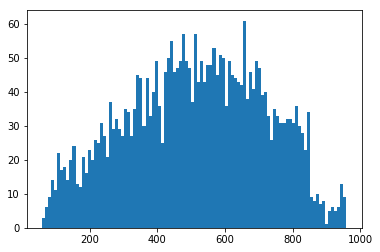

In [8]:
plt.hist(df_X_train["depths"].values, bins=100)
plt.show()

In [9]:
# batch_size = 128
epochs = 50
inChannel = 1
row_len, col_len = 64, 64
input_img = Input(shape = (3200,row_len, col_len, inChannel))
max_depths=max(list_depths)



#define variable input depth metrices
def get_depths_arr(list_depths,row_len,max_depths):
    out=[[[x]*row_len]*row_len for x in list_depths]*5
    out=np.array(out).astype('float32')/float(max_depths)
    out = np.reshape(out, (len(list_depths)*5, row_len, row_len, 1))
    print(out.shape,"123")
    return out

# get_depths_arr(df_X_train['depths'].values.tolist(),23,max_depths)


In [10]:


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)



In [11]:

from resnet50_d import identity_block
from resnet50_d import conv_block

In [12]:
input_img = Input(shape=(64,64, 1))    # adapt this if using 'channels_first' image data format

depth_input_8 = Input(shape=(8,8, 1), name='depth_input_8')
depth_input_16 = Input(shape=(16,16, 1), name='depth_input_16')
depth_input_32 = Input(shape=(32,32, 1), name='depth_input_32')
depth_input_64 = Input(shape=(64,64, 1), name='depth_input_64')
# depth_input_128 = Input(shape=(128,128, 1), name='depth_input_128')

## BLOCK == "a"
conv1_1= Conv2D(16, 3, activation='relu', padding='same')(input_img)
# conv1_2= Conv2D(8, 3, activation='relu', padding='same')(conv1_1)
conv1_2=identity_block(conv1_1, 3, [4,4,16], stage=1, block='a')
# pool_1 = MaxPooling2D((2, 2), padding='same')(conv1_2)
pool_1=conv_block(conv1_2, 3, [4,4,16], stage=1, block='a')
pool_1=Dropout(0.2)(pool_1)


## BLOCK == "b"
conv2_1= Conv2D(32, 3, activation='relu', padding='same')(pool_1)
# conv2_2= Conv2D(16, 3, activation='relu', padding='same')(conv2_1)
conv2_2=identity_block(conv2_1, 3, [8,8,32], stage=2, block='b')
# pool_2= MaxPooling2D((2, 2), padding='same')(conv2_2)
pool_2=conv_block(conv2_2, 3, [8,8,32], stage=2, block='b')
pool_2=Dropout(0.2)(pool_2)


## BLOCK == "c"
conv3_1= Conv2D(64, 3, activation='relu', padding='same')(pool_2)
# conv3_2= Conv2D(32, 3, activation='relu', padding='same')(conv3_1)
conv3_2=identity_block(conv3_1, 3, [16,16,64], stage=2, block='c')
# pool_3= MaxPooling2D((2, 2), padding='same')(conv3_2)
pool_3=conv_block(conv3_2, 3, [16,16,64], stage=2, block='c')
pool_3=Dropout(0.2)(pool_3)

## BLOCK == "d"
conv4_1= Conv2D(64, 3, activation='relu', padding='same')(pool_3)
# conv4_2= Conv2D(32, 3, activation='relu', padding='same')(conv4_1)
conv4_2=identity_block(conv4_1, 3, [16,16,64], stage=2, block='d')
# encoded = MaxPooling2D((2, 2), padding='same')(conv4_2)
encoded=conv_block(conv4_2, 3, [16,16,64], stage=2, block='d')



# at this point the representation is (4, 4, 8), i.e. 128-dimensional

up4_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (encoded)
merge_4=concatenate([up4_1, conv4_2,depth_input_8])
# merge_4=Dropout(0.2)(merge_4)
up4_2 = Conv2D(64, 3, activation='relu', padding='same')(merge_4)
up4_3 = Conv2D(64, 3, activation='relu', padding='same')(up4_2)


up3_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (up4_3)
merge_3=concatenate([up3_1, conv3_2])
# merge_3=concatenate([up3_1, conv3_2,depth_input_16])
# merge_3=Dropout(0.2)(merge_3)
up3_2 = Conv2D(64, 3, activation='relu', padding='same')(merge_3)
up3_3 = Conv2D(64, 3, activation='relu', padding='same')(up3_2)


up2_1 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (up3_3)
merge_2=concatenate([up2_1, conv2_2])
# merge_2=concatenate([up2_1, conv2_2,depth_input_32])
# merge_2=Dropout(0.2)(merge_2)
up2_2 = Conv2D(32, 3, activation='relu', padding='same')(merge_2)
up2_2 = Conv2D(32, 3, activation='relu', padding='same')(up2_2)



up1_1 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(up2_2)
merge_1=concatenate([up1_1, conv1_2])
# merge_1=concatenate([up1_1, conv1_2,depth_input_64])
# merge_1=Dropout(0.2)(merge_1)
up1_2 = Conv2D(16, 3, activation='relu', padding='same')(merge_1)
up1_3 = Conv2D(16, 3, activation='relu', padding='same')(up1_2)


up0_0 = Conv2D(8, 2, activation='relu', padding='same')(up1_3)
up0_1 = Conv2D(1, 1, activation="sigmoid", padding='same')(up0_0)


autoencoder = Model(inputs=[input_img, depth_input_8], outputs=[up0_1])

autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 4)    68          conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 4)    16          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation

In [13]:
from keras.models import load_model
# autoencoder.save('autoencode_test.h5')
# autoencoder=load_model('model-tgs-salt-4-1.h5', custom_objects={'mean_iou': mean_iou})

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=[mean_iou] )


In [14]:
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.001, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt_res_2-1.h5', verbose=1, save_best_only=True)


## define5 fold validation 

In [15]:
autoencoder_train = autoencoder.fit([X_train,
                                     get_depths_arr(df_X_train['depths'].values.tolist(),8,max_depths)],
                                    [y_train], 
                                    batch_size=116,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=(
                                        [X_test,get_depths_arr(df_X_test['depths'].values.tolist(),8,max_depths)],
                                        [y_test]),
                                    
                                    callbacks=[earlystopper, checkpointer,reduce_lr])

(15680, 8, 8, 1) 123
(3920, 8, 8, 1) 123
Train on 15680 samples, validate on 3920 samples
Epoch 1/100
15680/15680 [==============================] - 47s 3ms/step - loss: 0.4177 - mean_iou: 0.4111 - val_loss: 0.9009 - val_mean_iou: 0.4722

Epoch 00001: val_loss improved from inf to 0.90093, saving model to model-tgs-salt_res_2-1.h5
Epoch 2/100
15680/15680 [==============================] - 41s 3ms/step - loss: 0.3192 - mean_iou: 0.5032 - val_loss: 0.7359 - val_mean_iou: 0.5252

Epoch 00002: val_loss improved from 0.90093 to 0.73588, saving model to model-tgs-salt_res_2-1.h5
Epoch 3/100
15680/15680 [==============================] - 121s 8ms/step - loss: 0.2889 - mean_iou: 0.5409 - val_loss: 0.3710 - val_mean_iou: 0.5652

Epoch 00003: val_loss improved from 0.73588 to 0.37104, saving model to model-tgs-salt_res_2-1.h5
Epoch 4/100
15680/15680 [==============================] - 365s 23ms/step - loss: 0.2775 - mean_iou: 0.5820 - val_loss: 0.5019 - val_mean_iou: 0.5900

Epoch 00004: val_loss

KeyboardInterrupt: 

# Prepare dividing array

In [16]:
def get_101_dividing_np_array():
    ps=np.array([101,101])
    cs=np.array([64,64])
    ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])
    
    

    child_1=np.zeros(cs)+1
    child_2=np.zeros(cs)+1
    child_3=np.zeros(cs)+1
    child_4=np.zeros(cs)+1
    child_mid=np.zeros(cs)+1
    
    all_child_array=np.zeros((101,101),dtype=float)
    all_child_array[:cs[0],:cs[0]]=all_child_array[:cs[0],:cs[0]]+child_1
    all_child_array[-cs[0]:,:cs[0]]=all_child_array[-cs[0]:,:cs[0]]+child_2
    all_child_array[:cs[0],-cs[0]:]=all_child_array[:cs[0],-cs[0]:]+child_3
    all_child_array[-cs[0]:,-cs[0]:]=all_child_array[-cs[0]:,-cs[0]:]+child_4

    all_child_array[ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=all_child_array[ch_mid_idx[0]:ch_mid_idx[1],
                                                                                             ch_mid_idx[0]:ch_mid_idx[1]]+child_mid
    
    return all_child_array


## prepare for X_test prediction 

In [19]:
autoencoder=load_model('model-tgs-salt_res_2-1.h5', custom_objects={'mean_iou': mean_iou})

pred_imgs_64=autoencoder.predict([X_test,
                              get_depths_arr(df_X_test['depths'].values.tolist(),8,max_depths)],verbose=1)

preds_img_101=np.zeros((int(X_test.shape[0]/5),101,101),dtype=float)
preds_img_101[:,:cs[0],:cs[0]]=preds_img_101[:,:cs[0],:cs[0]]+pred_imgs_64[0:preds_img_101.shape[0],:,:,0]
preds_img_101[:,-cs[0]:,:cs[0]]=preds_img_101[:,-cs[0]:,:cs[0]]+pred_imgs_64[preds_img_101.shape[0]:preds_img_101.shape[0]*2,:,:,0]
preds_img_101[:,:cs[0],-cs[0]:]=preds_img_101[:,:cs[0],-cs[0]:]+pred_imgs_64[preds_img_101.shape[0]*2:preds_img_101.shape[0]*3,:,:,0]
preds_img_101[:,-cs[0]:,-cs[0]:]=preds_img_101[:,-cs[0]:,-cs[0]:]+pred_imgs_64[preds_img_101.shape[0]*3:preds_img_101.shape[0]*4,:,:,0]

preds_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=preds_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]+pred_imgs_64[preds_img_101.shape[0]*4:preds_img_101.shape[0]*5,:,:,0]


preds_img_101_c=preds_img_101/get_101_dividing_np_array()*255.0
# preds_img_101=(preds_img_101>127.5).astype(np.uint8)





(3920, 8, 8, 1) 123
3920/3920 [==============================] - 4s 1ms/step


10200.0 10201.0
9968.0 10200.0
9926.0 10200.0
9911.0 10200.0
9893.0 10200.0
9879.0 10200.0
9869.0 10200.0
9859.0 10200.0
9845.0 10200.0
9836.0 10200.0
9823.0 10200.0
9816.0 10200.0
9801.0 10200.0
9791.0 10200.0
9781.0 10200.0
9771.0 10200.0
9764.0 10200.0
9754.0 10200.0
9745.0 10200.0
9736.0 10200.0
9728.0 10200.0
9722.0 10200.0
9716.0 10200.0
9710.0 10200.0
9700.0 10200.0
9693.0 10200.0
9683.0 10200.0
9677.0 10200.0
9672.0 10200.0
9666.0 10200.0
9661.0 10200.0
9653.0 10200.0
9652.0 10200.0
9643.0 10200.0
9635.0 10200.0


C:\Users\Rahul\Anaconda3\envs\tensorflow_1\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


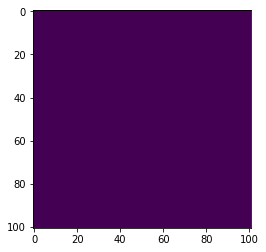

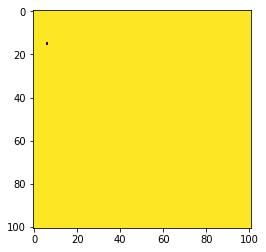

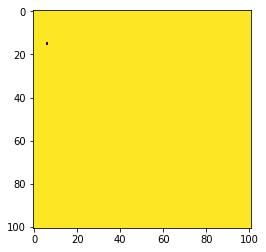

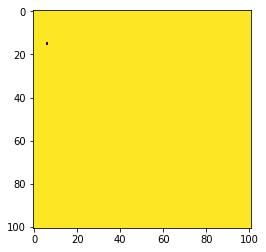

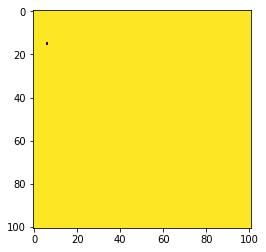

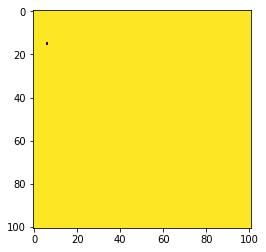

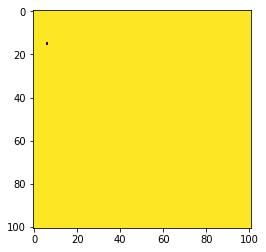

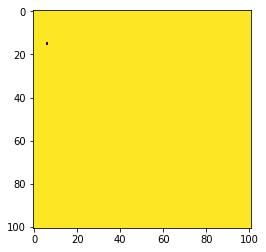

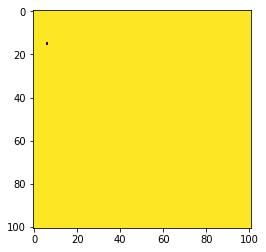

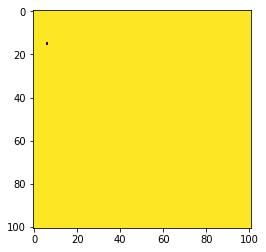

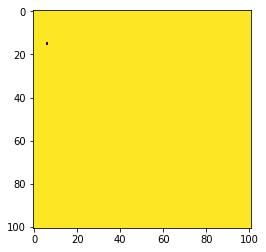

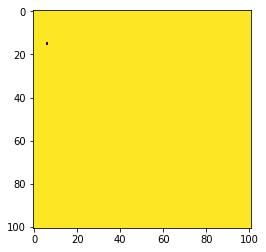

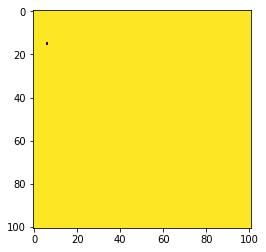

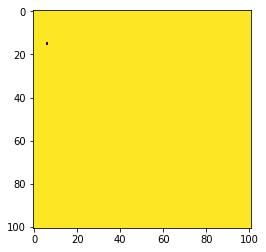

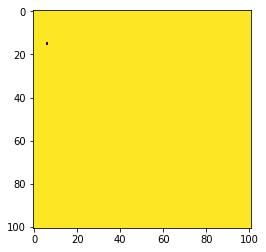

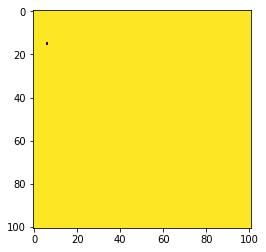

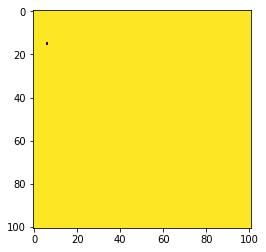

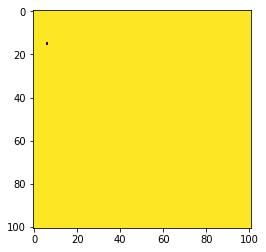

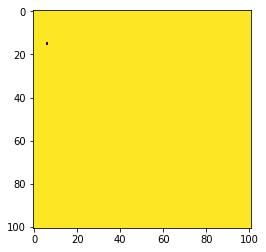

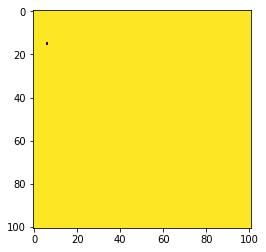

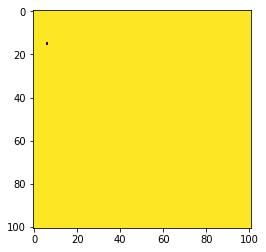

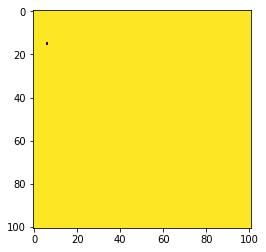

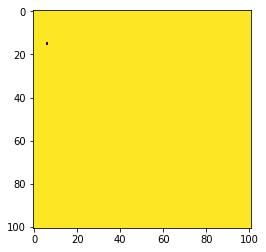

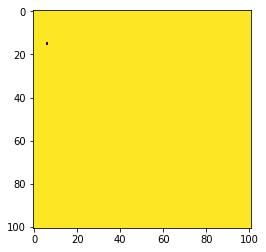

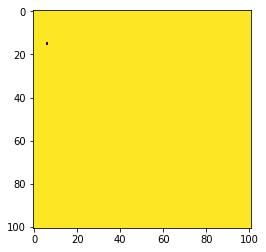

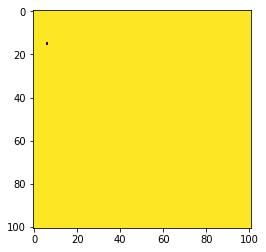

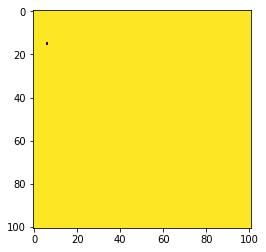

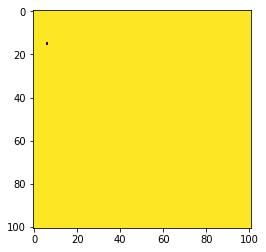

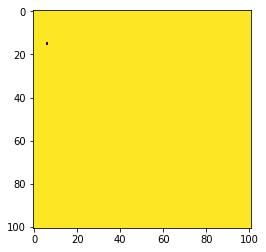

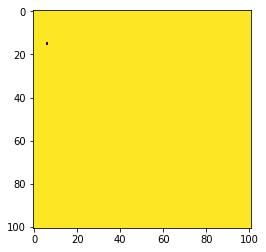

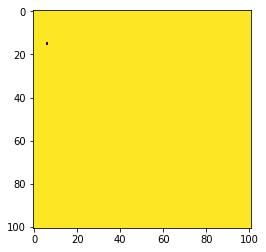

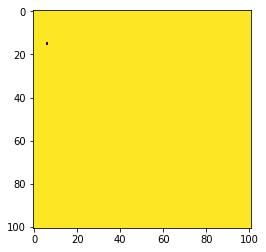

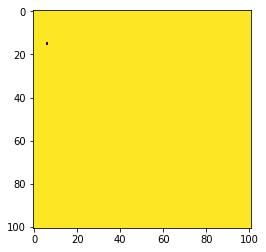

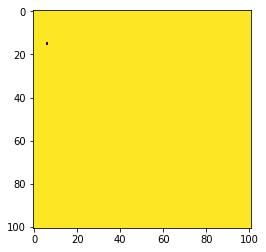

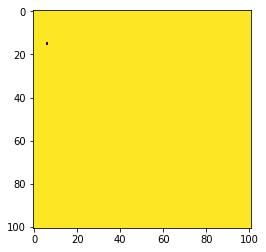

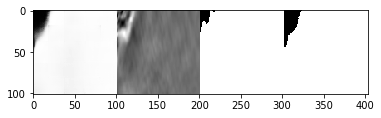

In [50]:
preds_img_101_c#255

def get_iou_of_perdict_vs_actual(pred,actual):
    list_th_iou=[]
    for th in range(0,175,5):
        pred_th=pred>th
        intersection=np.logical_and(pred_th,actual)
        union=np.logical_or(pred_th,actual)
        print(float(np.sum(intersection)),float(np.sum(union)))
        iou=float(np.sum(intersection))/float(np.sum(union))
        list_th_iou.append(iou)
        plt.figure()
        plt.imshow(union)
        
    return list_th_iou

list_list_th_iou=[]
for i in range(1):#preds_img_101_c.shape[0]
    img=preds_img_101_c[i]
    list_list_th_iou.append(get_iou_of_perdict_vs_actual(img,X_test_101_org[i]))
    plt.figure()
    plt.imshow(np.concatenate((img,X_test_101_org[i],y_test_101_org[i],(img>127.5)*255), axis=1),cmap='gray')
    
    

In [44]:
def Average(lst): 
    return sum(lst) / len(lst) 
[Average(x) for x in np.array(list_list_th_iou).T.tolist()]
np.array(list_list_th_iou)

array([[9.99901970e-01, 9.77254902e-01, 9.73137255e-01, 9.71666667e-01,
        9.69901961e-01, 9.68529412e-01, 9.67549020e-01, 9.66568627e-01,
        9.65196078e-01, 9.64313725e-01, 9.63039216e-01, 9.62352941e-01,
        9.60882353e-01, 9.59901961e-01, 9.58921569e-01, 9.57941176e-01,
        9.57254902e-01, 9.56274510e-01, 9.55392157e-01, 9.54509804e-01,
        9.53725490e-01, 9.53137255e-01, 9.52549020e-01, 9.51960784e-01,
        9.50980392e-01, 9.50294118e-01, 9.49313725e-01, 9.48725490e-01,
        9.48235294e-01, 9.47647059e-01, 9.47156863e-01, 9.46372549e-01,
        9.46274510e-01, 9.45392157e-01, 9.44607843e-01],
       [9.99803941e-01, 4.23137255e-01, 9.02049221e-02, 2.38258653e-02,
        6.07902736e-03, 5.88292970e-04, 9.80488283e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs
    
    
    
    
"""
OPTION-2
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



# pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}
# sub = pd.DataFrame.from_dict(pred_dict,orient='index')
# sub.index.names = ['id']
# sub.columns = ['rle_mask']
# sub.to_csv('submission.csv')

# prepare final predictions for submission

In [ ]:
# import all images

X_preds=[]
X_preds_img_id=[]
list_X_preds_depths=[]

output_blank_id=[]


for i,img_path in enumerate(glob(PATH+"\\data\\test\\images\\*")):
    img_id=os.path.basename(os.path.normpath(img_path.split(".")[0]))
    n=np.array(cv2.imread(img_path))
    
    if np.average(n)!=0:
        n=cv2.resize(n,(101,101),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY).astype('float32') / 255.
        n_depth=df_depth[df_depth["id"]==img_id+".png"]['z'].values[0]
        
        X_preds_img_id.append(img_id)
        X_preds.append(n)
        list_X_preds_depths.append(n_depth)
        
    else:
        output_blank_id.append(img_id)

# X_preds Prepareations 
X_preds = np.array(X_preds)
X_preds = get_101_img_to_64(X_preds)
X_preds = np.reshape(X_preds, (len(X_preds), 64, 64, 1))

# import model and then use that mosel to predict images

submi_img_64=autoencoder.predict([X_preds,
                              get_depths_arr(list_X_preds_depths,8,max_depths)],verbose=1)



submi_img_101=np.zeros((int(X_preds.shape[0]/5),101,101),dtype=float)
submi_img_101[:,:cs[0],:cs[0]]=submi_img_101[:,:cs[0],:cs[0]]+submi_img_64[0:submi_img_101.shape[0],:,:,0]
submi_img_101[:,-cs[0]:,:cs[0]]=submi_img_101[:,-cs[0]:,:cs[0]]+submi_img_64[submi_img_101.shape[0]:submi_img_101.shape[0]*2,:,:,0]
submi_img_101[:,:cs[0],-cs[0]:]=submi_img_101[:,:cs[0],-cs[0]:]+submi_img_64[submi_img_101.shape[0]*2:submi_img_101.shape[0]*3,:,:,0]
submi_img_101[:,-cs[0]:,-cs[0]:]=submi_img_101[:,-cs[0]:,-cs[0]:]+submi_img_64[submi_img_101.shape[0]*3:submi_img_101.shape[0]*4,:,:,0]

submi_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=submi_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]+submi_img_64[submi_img_101.shape[0]*4:submi_img_101.shape[0]*5,:,:,0]


submi_img_101_c=submi_img_101/get_101_dividing_np_array()*255.0
submi_img_101_c=(submi_img_101_c>127.5).astype(np.uint8)

output_X_submi=[RLenc(submi_img_101_c[i], order='F', format=True) for i in range(len(submi_img_101_c))]



In [ ]:
sub = pd.DataFrame()
sub['id']=X_preds_img_id + output_blank_id
sub['rle_mask']=output_X_submi + [np.nan for i in range(len(output_blank_id))]

sub.to_csv('submission2.csv',index=False)
sub